In [ ]:
# !pip install git+https://github.com/statsmodels/statsmodels

In [ ]:
def test_stationarity(timeseries):
  import matplotlib.pyplot as plt
  rolmean = timeseries.rolling(window=5).mean()
  rolstd = timeseries.rolling(window=5).std()

  orig = plt.plot(timeseries, label='Original')
  mean = plt.plot(rolmean, label='Rolling mean')
  std  = plt.plot(rolstd, label='Rolling std')

  plt.legend(loc='best')
  plt.title('Timeseries data with rolling mean and std. dev.')
  plt.show()
    
  from statsmodels.tsa.stattools import adfuller

  dftest = adfuller(timeseries)
  dfoutput = pd.Series(dftest[0:4], index = ['The test statistic','MacKinnon’s approximate p-value','#usedLags','NOBS'])

  print(dfoutput)

In [ ]:
file_location='/content/covid_19_data.csv'

import pandas as pd

covid_19_dataset = pd.read_csv(file_location)

covid_19_dataset.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
covid_19_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              306429 non-null  int64  
 1   ObservationDate  306429 non-null  object 
 2   Province/State   228329 non-null  object 
 3   Country/Region   306429 non-null  object 
 4   Last Update      306429 non-null  object 
 5   Confirmed        306429 non-null  float64
 6   Deaths           306429 non-null  float64
 7   Recovered        306429 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 18.7+ MB


In [ ]:
#object => datetime
covid_19_dataset['ObservationDate']=pd.to_datetime(covid_19_dataset['ObservationDate'], infer_datetime_format=True)

indexed_covid_19_dataset = covid_19_dataset.set_index(['ObservationDate'])

indexed_covid_19_dataset.head()

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
2020-01-22,1,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,2,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2020-01-22,3,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
2020-01-22,4,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,5,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
covid_data_india = indexed_covid_19_dataset['Country/Region'] == 'India'

covid_india_dataset = indexed_covid_19_dataset[covid_data_india]

covid_india_confirmed_case_dataset = covid_india_dataset['Confirmed']

covid_india_confirmed_agg_dataset = covid_india_confirmed_case_dataset.groupby(['ObservationDate']).sum()

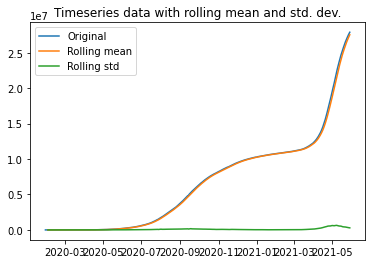

The test statistic                   1.791630
MacKinnon’s approximate p-value      0.998332
#usedLags                           16.000000
NOBS                               469.000000
dtype: float64


In [ ]:
test_stationarity(covid_india_confirmed_agg_dataset)

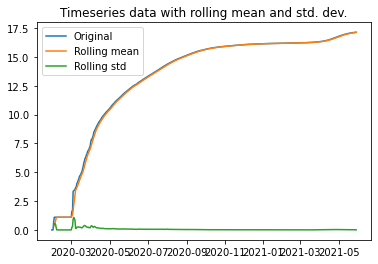

The test statistic                -6.499326e+00
MacKinnon’s approximate p-value    1.172548e-08
#usedLags                          2.000000e+00
NOBS                               4.830000e+02
dtype: float64


In [ ]:
import numpy as np

covid_india_confirmed_agg_dataset_log_scaled = np.log(covid_india_confirmed_agg_dataset) 

test_stationarity(covid_india_confirmed_agg_dataset_log_scaled)

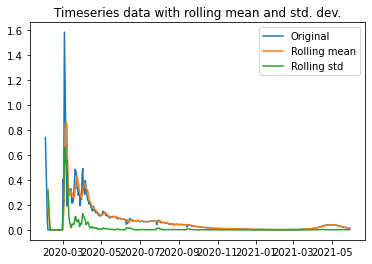

The test statistic                  -3.338102
MacKinnon’s approximate p-value      0.013259
#usedLags                            8.000000
NOBS                               473.000000
dtype: float64


In [ ]:
ma = covid_india_confirmed_agg_dataset_log_scaled.rolling(window=5).mean()
covid_india_confirmed_agg_dataset_log_scaled_minus_ma = covid_india_confirmed_agg_dataset_log_scaled - ma
covid_india_confirmed_agg_dataset_log_scaled_minus_ma.dropna(inplace=True)
test_stationarity(covid_india_confirmed_agg_dataset_log_scaled_minus_ma)

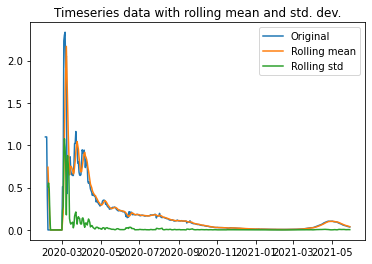

The test statistic                  -2.374772
MacKinnon’s approximate p-value      0.148984
#usedLags                           17.000000
NOBS                               463.000000
dtype: float64


In [ ]:
covid_india_confirmed_agg_dataset_log_scaled_ps = covid_india_confirmed_agg_dataset_log_scaled.diff(periods=5)

covid_india_confirmed_agg_dataset_log_scaled_ps.dropna(inplace=True)
test_stationarity(covid_india_confirmed_agg_dataset_log_scaled_ps)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


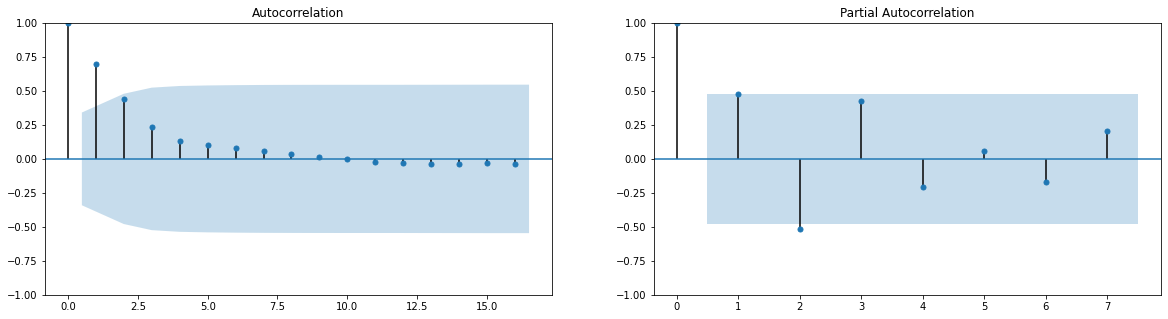

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt


lag_acf = acf(covid_india_confirmed_agg_dataset_log_scaled_minus_ma, nlags = 32)
lag_pacf = pacf(covid_india_confirmed_agg_dataset_log_scaled_minus_ma, nlags = 16)

fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(lag_acf, ax=ax[0])
plot_pacf(lag_pacf,lags=7, ax=ax[1])

plt.show()

In [ ]:
def predict(timeseries,p,d,q):
  
  from statsmodels.tsa.arima.model import ARIMA


  from sklearn.model_selection import train_test_split

  timeseries.dropna(inplace=True)

  train, test = train_test_split(timeseries, test_size = 0.20, shuffle=False)



  #ARIMA model
  model_arima = ARIMA(train, order=(p,d,q))

  model_arima_fit = model_arima.fit()

  predictions = model_arima_fit.predict(start='2021-02-22', end='2021-12-29')

  # from sklearn.metrics import mean_squared_error

  # error= mean_squared_error(test, predictions)

  # print('Test MSE %.5f' % error)

  predict = np.exp(predictions)
  test_set = np.exp(test)

  plt.plot(test_set)
  plt.plot(predict, color='red')
  plt.show()

  from pandas import DataFrame

  residual = DataFrame(model_arima_fit.resid)

  residual.plot(kind='kde')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters

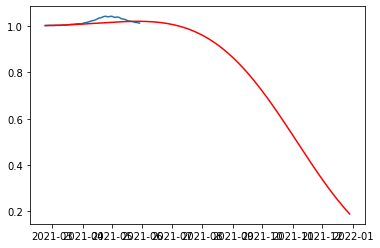

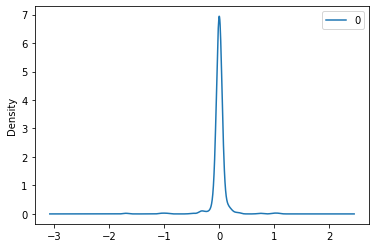

In [ ]:
predict(covid_india_confirmed_agg_dataset_log_scaled_minus_ma,40,5,3)

In [ ]:
  from sklearn.model_selection import train_test_split

  covid_india_confirmed_agg_dataset_log_scaled_minus_ma.dropna(inplace=True)

  train, test = train_test_split(covid_india_confirmed_agg_dataset_log_scaled_minus_ma, test_size = 0.20, shuffle=False)
  test.head()
  # test.tail()

ObservationDate
2021-02-22    0.002318
2021-02-23    0.002350
2021-02-24    0.002604
2021-02-25    0.002800
2021-02-26    0.002947
Name: Confirmed, dtype: float64